# Exploratory Data Analysis - Patient, consommant et hospitalisation

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
patient=pd.read_csv("patient_anonyme.csv")
hospit_non_chr=pd.read_csv("base_hospit_non_chr_anonyme.csv")

/tmp/ipykernel_1040/1855722776.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  hospit_non_chr=pd.read_csv("base_hospit_non_chr_anonyme.csv")


## Description de la population (base patient)

In [3]:
patient.head()

,date_h0,ALD_before,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,CODE_PATIENT,Mort,Nb_survie
0,2011-11-22,0,1949,11,1,NaN,P0,False,2596
1,2013-12-05,0,1929,14,2,2015-03,P6,True,456
2,2015-07-02,0,1967,54,2,2015-08,P8,True,41
3,2011-05-19,0,1959,974,1,NaN,P13,False,2783
4,2010-03-18,0,1947,76,1,NaN,P16,False,3210


In [4]:
patient.describe()

,ALD_before,y_nais,BEN_SEX_COD,Nb_survie
count,10052.0,10052.000000,10052.000000,10052.000000
mean,0.0,1934.601870,1.512037,1130.750398
std,0.0,13.537071,0.499880,951.323657
min,0.0,1907.000000,1.000000,0.000000
25%,0.0,1925.000000,1.000000,171.000000
50%,0.0,1931.000000,2.000000,1101.000000
75%,0.0,1942.000000,2.000000,1836.000000
max,0.0,1997.000000,2.000000,3384.000000


### Âges, sexes, et décès des patients

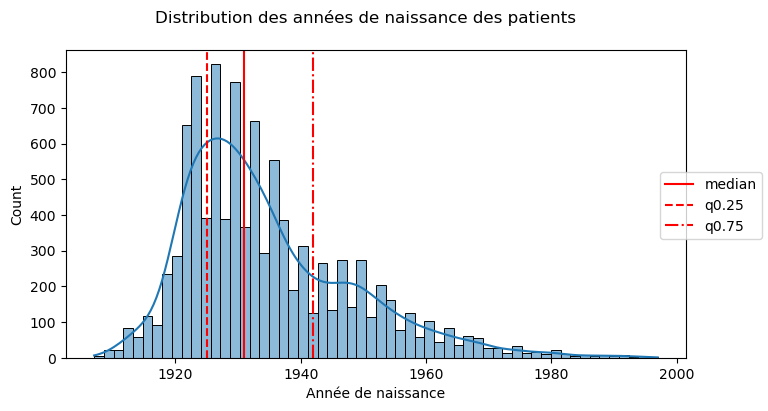

In [5]:
fig, ax = f, ax = plt.subplots()
fig.set_size_inches(8, 4)
sns.histplot(data=patient, x="y_nais", kde=True, ax=ax)
ax.axvline(x=patient.y_nais.median(), color='r', label='median')
ax.axvline(x=patient.y_nais.quantile(.25), color='r', linestyle='--', label='q0.25')
ax.axvline(x=patient.y_nais.quantile(.75), color='r', linestyle='-.', label='q0.75')
ax.set_xlabel("Année de naissance")
fig.suptitle("Distribution des années de naissance des patients")
fig.legend(loc=5)

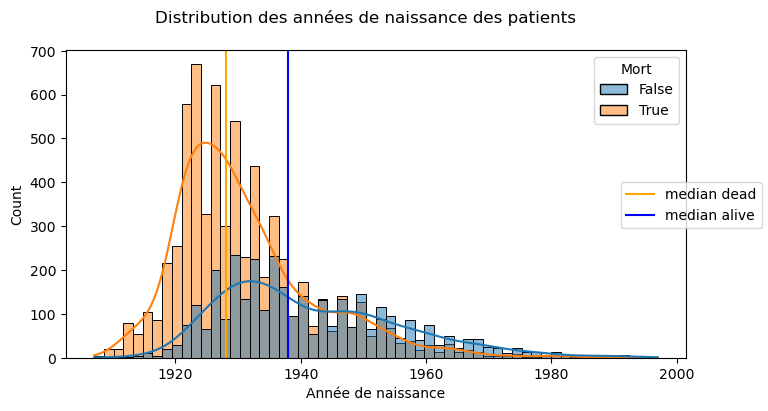

In [6]:
fig, ax = f, ax = plt.subplots()
fig.set_size_inches(8, 4)
sns.histplot(patient, x="y_nais", hue="Mort",
            kde=True,
            ax=ax,
            #stat="probability"
           )
ax.axvline(x=patient[patient["Mort"]==True].y_nais.median(), color='orange', label='median dead')
ax.axvline(x=patient[patient["Mort"]==False].y_nais.median(), color='blue', label='median alive')
ax.set_xlabel("Année de naissance")
fig.suptitle("Distribution des années de naissance des patients")
fig.legend(loc=5)

In [7]:
patient[patient['Mort']==False].describe()

,ALD_before,y_nais,BEN_SEX_COD,Nb_survie
count,3433.0,3433.000000,3433.000000,3433.000000
mean,0.0,1941.572094,1.489077,2033.184678
std,0.0,14.469971,0.499953,624.998717
min,0.0,1908.000000,1.000000,1096.000000
25%,0.0,1931.000000,1.000000,1468.000000
50%,0.0,1938.000000,1.000000,1951.000000
75%,0.0,1951.000000,2.000000,2545.000000
max,0.0,1997.000000,2.000000,3286.000000


+ L'année de naissance *moyenne* des patients qui ne sont pas décédés est : **1941**
+ L'année de naissance *médiane* des patients qui ne sont pas décédés est : **1938**

In [8]:
patient[patient['Mort']==True].describe()

,ALD_before,y_nais,BEN_SEX_COD,Nb_survie
count,6619.0,6619.000000,6619.000000,6619.000000
mean,0.0,1930.986705,1.523946,662.695271
std,0.0,11.465459,0.499464,728.250595
min,0.0,1907.000000,1.000000,0.000000
25%,0.0,1923.000000,1.000000,48.500000
50%,0.0,1928.000000,2.000000,388.000000
75%,0.0,1936.000000,2.000000,1082.000000
max,0.0,1994.000000,2.000000,3384.000000


+ L'année de naissance *moyenne* des patients décédés est : **1930**
+ L'année de naissance *médiane* des patients décédés est : **1928**

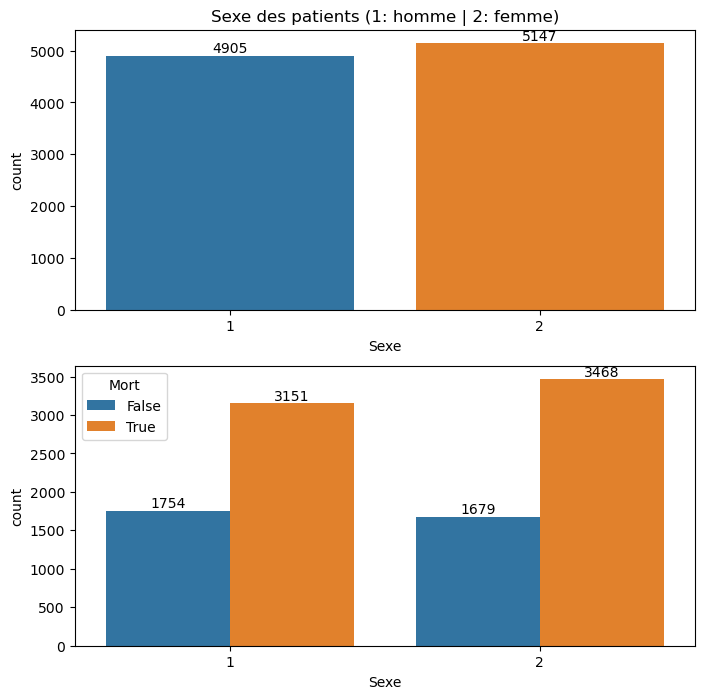

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(8, 8)

sns.countplot(x="BEN_SEX_COD", data=patient, ax=ax1)
ax1.set_title("Sexe des patients (1: homme | 2: femme)")
ax1.bar_label(ax1.containers[0])
ax1.set_xlabel("Sexe")

sns.countplot(x="BEN_SEX_COD", hue="Mort", data=patient, ax=ax2)
ax2.set_xlabel("Sexe")
ax2.bar_label(ax2.containers[0])
ax2.bar_label(ax2.containers[1])

plt.show()

Le dataset est plutôt équilibré avec :
+ 5147 femmes (**51.2%** de la population totale)
+ 4905 hommes (**48.8%** de la population totale)

Concernant les patients décédés (6619, **66%** de la population totale) :
+ 3468 femmes (**52.4%** de la population décédée)
+ 3151 hommes (**47.6%** de la population décédée)

Concernant les patients en vie à la fin de l'étude (3433, **34%** de la population totale) :
+ 1679 femmes (**52.4%** de la population décédée)
+ 1754 hommes (**47.6%** de la population décédée)

<Figure size 1000x200 with 0 Axes>

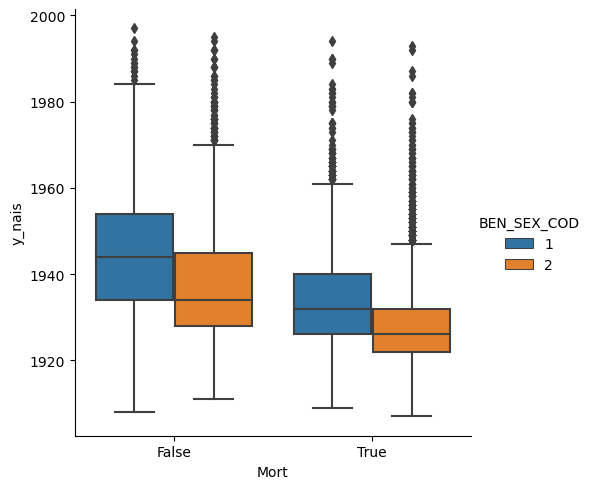

In [10]:
plt.figure(figsize=(10,2))
sns.catplot(data=patient, x="Mort", y="y_nais", hue="BEN_SEX_COD", kind="box")

### Etude de la variable Nb_survie

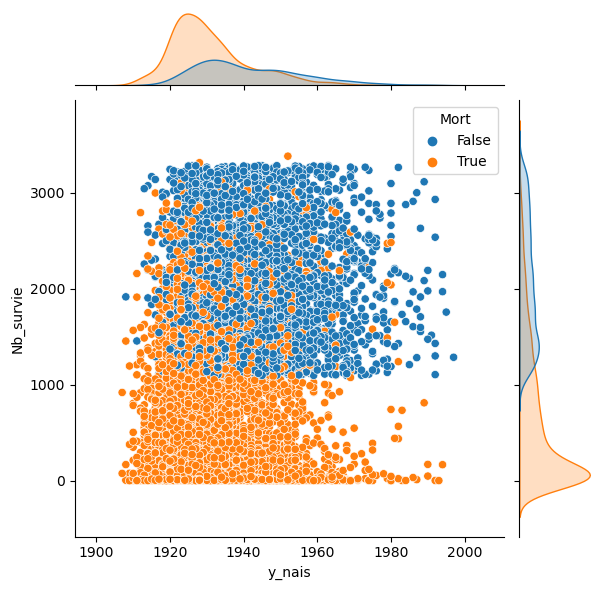

In [11]:
sns.jointplot(data=patient, x="y_nais", y="Nb_survie", hue="Mort")

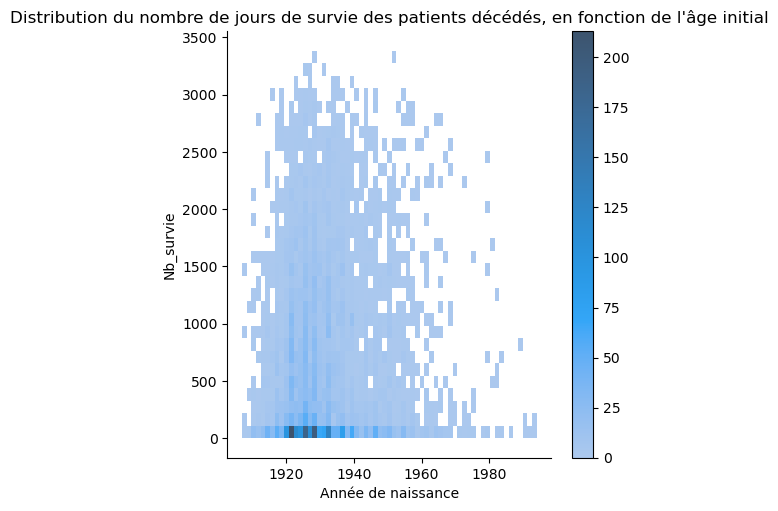

In [12]:
data=patient[patient["Mort"]==True]
titre="Distribution du nombre de jours de survie des patients décédés, en fonction de l'âge initial"
g=sns.displot(data, x="y_nais", y="Nb_survie", cbar=True,
            #kind="kde",
           ).set(title=titre)
g.set_axis_labels("Année de naissance")

## Corrélations

In [13]:
patient.drop("ALD_before", axis=1).corr()

/tmp/ipykernel_1040/26581249.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  patient.drop("ALD_before", axis=1).corr()


,y_nais,BEN_SEX_COD,Mort,Nb_survie
y_nais,1.000000,-0.236992,-0.370838,0.276225
BEN_SEX_COD,-0.236992,1.000000,0.033081,-0.017867
Mort,-0.370838,0.033081,1.000000,-0.683203
Nb_survie,0.276225,-0.017867,-0.683203,1.000000


/tmp/ipykernel_1040/2947206520.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(patient.drop("ALD_before", axis=1).corr(), vmin=-1, vmax=1, annot=True)


Text(0.5, 1.0, 'Correlation Heatmap')

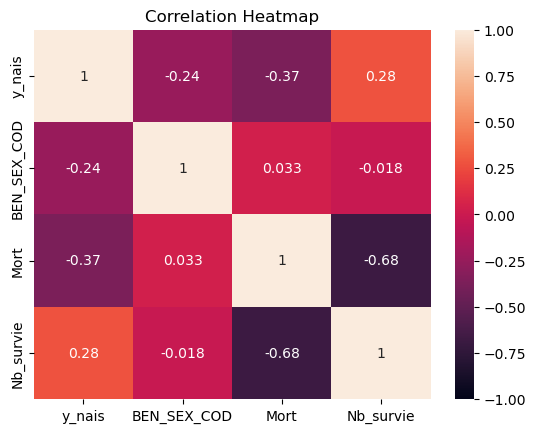

In [14]:
heatmap = sns.heatmap(patient.drop("ALD_before", axis=1).corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap')

+ **Sexe et décès très peu corrélés** (0.033)
+ Forte corrélation (attendue) entre les variables *Mort* et *Nb_survie* (-0.68)
+ Corrélation importante (attendue) entre *Mort* et *y_nais* (-0.37) 

## Pairplot

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


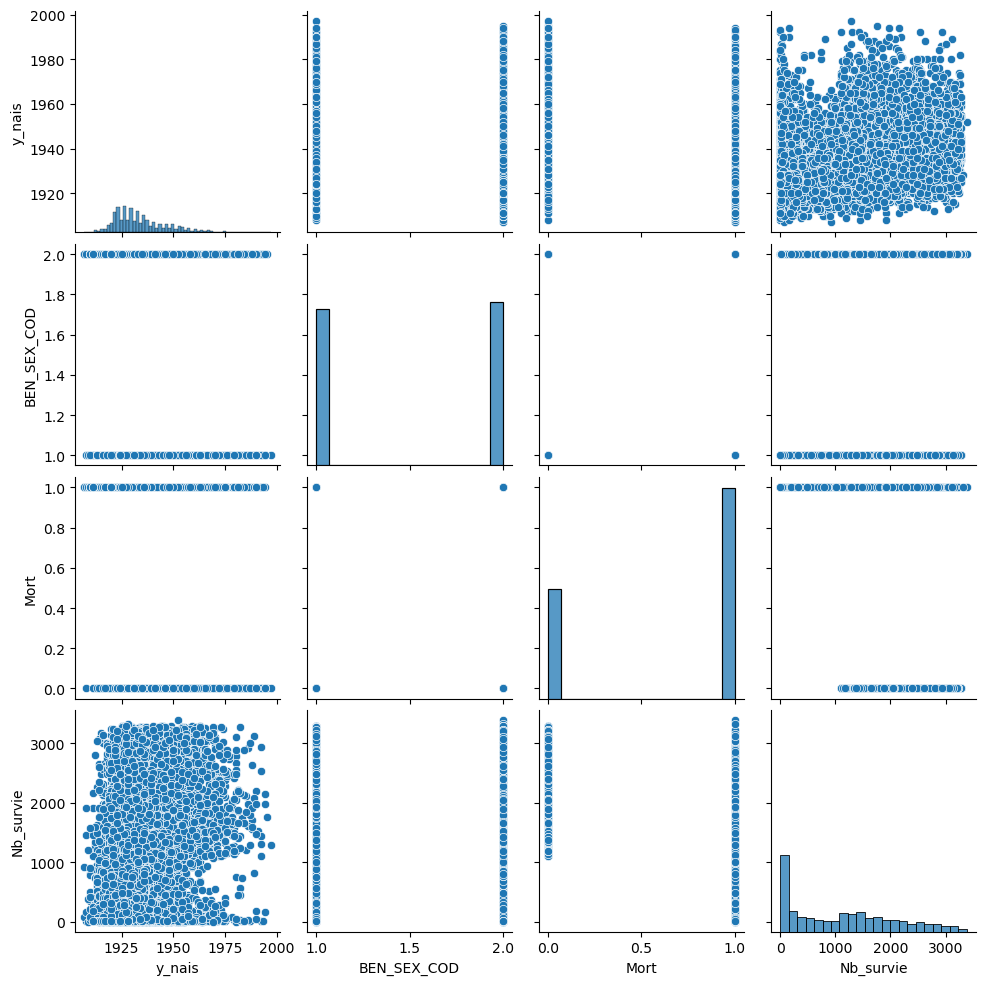

In [15]:
sns.pairplot(patient.drop("ALD_before", axis=1))

## Ajout des hospitalisations (base hospitalisations non chroniques)

### Ajout du nombre d'hospitalisations pour chaque patient

In [16]:
hospit_non_chr.head()

,RSA_NUM,ETA_NUM,EXE_SOI_DTD,SEJ_NBJ,GRG_GHM,DGN_PAL,DGN_REL,BEN_NIR_IDT,Mort,Nb_survie,CHOC,HEMOD,CHIMIO,Radiotherapie,Transfusion
0,144689,310781406,2011-11-22,2.0,05K051,I2100,NaN,P0,False,2596,0,0,0,0,0
1,2763,110780061,2011-11-24,8.0,05M042,I21000,NaN,P0,False,2596,0,0,0,0,0
2,15548,110780061,2011-12-08,0.0,05M16T,I255,NaN,P0,False,2596,0,0,0,0,0
3,5260,110780061,2012-03-04,1.0,05M09T,I501,NaN,P0,False,2596,0,0,0,0,0
4,112258,310781406,2012-03-05,7.0,05M092,I501,NaN,P0,False,2596,0,0,0,0,0


In [17]:
hospit=hospit_non_chr.groupby("BEN_NIR_IDT").count()[['RSA_NUM']].reset_index()
hospit=hospit.rename(columns={"BEN_NIR_IDT": "CODE_PATIENT", "RSA_NUM": "Nb_hospit"})

In [18]:
hospit=hospit.set_index("CODE_PATIENT")
hospit.head()

,Nb_hospit
CODE_PATIENT,
P0,9
P10001,9
P10003,3
P10004,8
P10006,1


In [19]:
patient=patient.set_index("CODE_PATIENT")
patient["Nb_hospit"]=hospit["Nb_hospit"]
patient=patient.drop("ALD_before", axis=1)
patient.head()

,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit
CODE_PATIENT,,,,,,,,
P0,2011-11-22,1949,11,1,NaN,False,2596,9.0
P6,2013-12-05,1929,14,2,2015-03,True,456,8.0
P8,2015-07-02,1967,54,2,2015-08,True,41,3.0
P13,2011-05-19,1959,974,1,NaN,False,2783,2.0
P16,2010-03-18,1947,76,1,NaN,False,3210,9.0


### Ajout des chocs

In [20]:
hospit_choc=hospit_non_chr.groupby("BEN_NIR_IDT").sum()[["CHOC"]]

/tmp/ipykernel_1040/1420949653.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hospit_choc=hospit_non_chr.groupby("BEN_NIR_IDT").sum()[["CHOC"]]


In [32]:
patient["CHOC"]=hospit_choc["CHOC"]>0

In [33]:
patient.head()

,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC
CODE_PATIENT,,,,,,,,,
P0,2011-11-22,1949,11,1,NaN,False,2596,9.0,False
P6,2013-12-05,1929,14,2,2015-03,True,456,8.0,False
P8,2015-07-02,1967,54,2,2015-08,True,41,3.0,True
P13,2011-05-19,1959,974,1,NaN,False,2783,2.0,False
P16,2010-03-18,1947,76,1,NaN,False,3210,9.0,False


In [34]:
patient.describe()

,y_nais,BEN_SEX_COD,Nb_survie,Nb_hospit
count,10052.000000,10052.000000,10052.000000,10051.000000
mean,1934.601870,1.512037,1130.750398,8.515969
std,13.537071,0.499880,951.323657,8.324717
min,1907.000000,1.000000,0.000000,1.000000
25%,1925.000000,1.000000,171.000000,4.000000
50%,1931.000000,2.000000,1101.000000,7.000000
75%,1942.000000,2.000000,1836.000000,11.000000
max,1997.000000,2.000000,3384.000000,255.000000


### Ajout du nombre de jours d'hospitalisations

In [39]:
hospit_Nb_jours_sej=hospit_non_chr.groupby("BEN_NIR_IDT").sum()[["SEJ_NBJ"]]
hospit_Nb_jours_sej

/tmp/ipykernel_1040/866682408.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hospit_Nb_jours_sej=hospit_non_chr.groupby("BEN_NIR_IDT").sum()[["SEJ_NBJ"]]


,SEJ_NBJ
BEN_NIR_IDT,
P0,23.0
P10001,55.0
P10003,26.0
P10004,73.0
P10006,22.0
...,...
P9984,10.0
P9985,6.0
P9987,187.0


In [40]:
patient["Nb_jours_sej"]=hospit_Nb_jours_sej["SEJ_NBJ"]

In [ ]:
patient.head()

,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,Nb_jours_sej
CODE_PATIENT,,,,,,,,,,
P0,2011-11-22,1949,11,1,NaN,False,2596,9.0,False,23.0
P6,2013-12-05,1929,14,2,2015-03,True,456,8.0,False,51.0
P8,2015-07-02,1967,54,2,2015-08,True,41,3.0,True,43.0
P13,2011-05-19,1959,974,1,NaN,False,2783,2.0,False,3.0
P16,2010-03-18,1947,76,1,NaN,False,3210,9.0,False,28.0


In [45]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10052 entries, P0 to P24310
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date_h0       10052 non-null  object 
 1   y_nais        10052 non-null  int64  
 2   BEN_RES_DPT   10052 non-null  object 
 3   BEN_SEX_COD   10052 non-null  int64  
 4   dte_deces     6619 non-null   object 
 5   Mort          10052 non-null  bool   
 6   Nb_survie     10052 non-null  int64  
 7   Nb_hospit     10051 non-null  float64
 8   CHOC          10051 non-null  object 
 9   Nb_jours_sej  10051 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(4)
memory usage: 795.1+ KB


In [47]:
patient=patient[patient['Nb_hospit'].notna()]

In [49]:
patient['Nb_hospit']=patient['Nb_hospit'].astype(int)
patient['Nb_jours_sej']=patient['Nb_jours_sej'].astype(int)

CODE_PATIENT
P0        23
P6        51
P8        43
P13        3
P16       28
          ..
P24302    47
P24303    86
P24304    10
P24308    99
P24310    29
Name: Nb_jours_sej, Length: 10051, dtype: int64

In [57]:
patient.to_csv("./data/profil_patient.csv")